In [1]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt 
import uproot
import mplhep as hep
hep.style.use("ROOT")

from tqdm import tqdm, trange

In [6]:
ambe_ntuple = "/nfs/disk1/users/jierans/eos/eos_run321.ntuple.root"
rootfile = uproot.open(ambe_ntuple)
events = rootfile['output']
meta = rootfile['meta']

pmtinfo = {}
pmtx = meta['pmtX'].array(library='numpy')[0]
pmty = meta['pmtY'].array(library='numpy')[0]
pmtz = meta['pmtZ'].array(library='numpy')[0]
pmtu = meta['pmtU'].array(library='numpy')[0]
pmtv = meta['pmtV'].array(library='numpy')[0]
pmtw = meta['pmtW'].array(library='numpy')[0]
pmtid = meta['pmtId'].array(library='numpy')[0]
pmttype = meta['pmtType'].array(library='numpy')[0]
pmt_lcn = meta['pmtChannel'].array(library='numpy')[0]

digitNCrossings = events['digitNCrossings'].array()

pmt_pos = np.stack([pmtx, pmty, pmtz], axis=1)
pmt_dir = np.stack([pmtu, pmtv, pmtw], axis=1)

pmtinfo['pos'] = pmt_pos
pmtinfo['dir'] = pmt_dir
pmtinfo['id'] = pmtid
pmtinfo['type'] = pmttype
pmtinfo['lcn'] = pmt_lcn

events.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
mcpdg                | int32_t                  | AsDtype('>i4')
mcx                  | double                   | AsDtype('>f8')
mcy                  | double                   | AsDtype('>f8')
mcz                  | double                   | AsDtype('>f8')
mcu                  | double                   | AsDtype('>f8')
mcv                  | double                   | AsDtype('>f8')
mcw                  | double                   | AsDtype('>f8')
mcke                 | double                   | AsDtype('>f8')
mct                  | double                   | AsDtype('>f8')
evid                 | int32_t                  | AsDtype('>i4')
subev                | int32_t                  | AsDtype('>i4')
nhits                | int32_t                  | AsDtype('>i4')
triggerTime          | double                   | AsDtype(

In [4]:
ambe_ntuple = "/nfs/disk1/eos/water_fill/deployed_source/ambe/run321/ambe321.root"
rootfile = uproot.open(ambe_ntuple)
events = rootfile['events']
meta = rootfile['meta']
nhits = events['nhit'].array(library='np')
deltats = events['deltat'].array(library='np')
fitted_times = events['fitted_time'].array()
lcns = events['lcn'].array()
all_lcns = ak.to_numpy(ak.flatten(lcns))
all_fitted_times = ak.to_numpy(ak.flatten(fitted_times))
events.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
event_number         | int32_t                  | AsDtype('>i4')
nhit                 | int32_t                  | AsDtype('>i4')
total_charge         | double                   | AsDtype('>f8')
deltat               | double                   | AsDtype('>f8')
channel              | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
board                | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
lcn                  | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
time                 | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
channel15_time       | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
pedestal             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
charge               | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
charge_shor

In [11]:
ak.count_nonzero(digitNCrossings, axis=1)

<Array [222, 125, 27, 25, 175, ..., 52, 14, 224, 227] type='499539 * int64'>

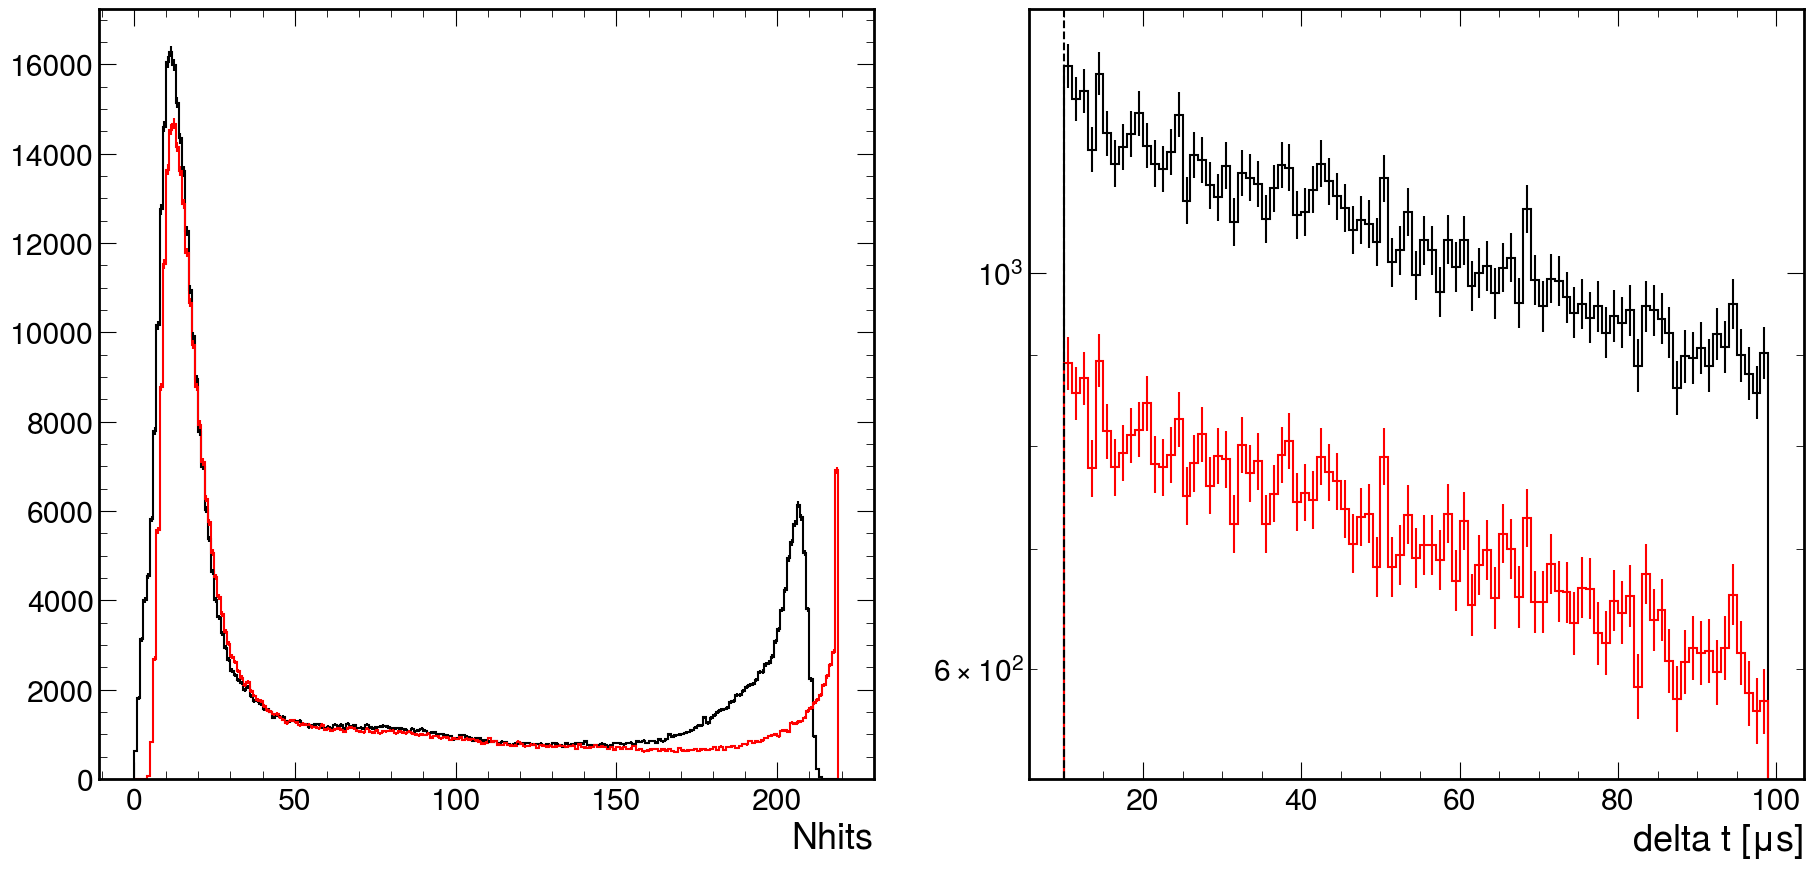

In [13]:
plt.figure(figsize=(22, 10))
plt.subplot(121)
nhits_hist = np.histogram(nhits, bins=np.arange(220))
hep.histplot(nhits_hist, yerr=True, color='k')
ncrossing_hist = np.histogram(ak.to_numpy(ak.count_nonzero(digitNCrossings, axis=1)), bins=np.arange(220))
hep.histplot(ncrossing_hist, yerr=True, color='r')
plt.xlabel("Nhits")

plt.subplot(122)
# deltats_hist = np.histogram(deltats, bins=10**np.arange(0, 3, 0.1), density=True)
# hep.histplot(deltats_hist, yerr=False, color='k')
# plt.semilogx()

deltats_hist = np.histogram(deltats, bins=np.arange(10, 100))
hep.histplot(deltats_hist, yerr=True, color='k')

deltats_hist = np.histogram(deltats[nhits < 75], bins=np.arange(10, 100))
hep.histplot(deltats_hist, yerr=True, color='r')

plt.xlabel(r"delta t [$\mu s$]")
plt.semilogy()
plt.axvline(10.0, color='k', linestyle='--')


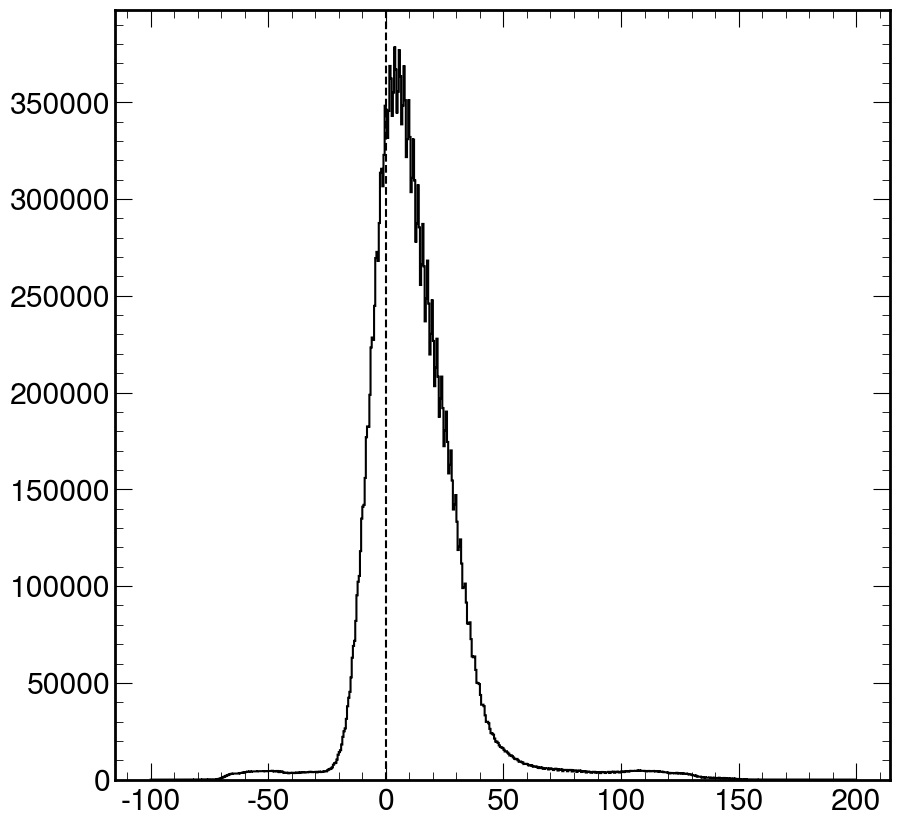

In [44]:
from CABLE_DELAYS import CABLE_DELAYS
CABLE_DELAYS = np.asarray(CABLE_DELAYS)
cabel_delay_for_hits = CABLE_DELAYS[all_lcns]
fitted_times_hist = np.histogram(all_fitted_times - cabel_delay_for_hits+30, bins=np.arange(-100, 200, 0.5))
hep.histplot(fitted_times_hist, yerr=True, color='k')
plt.axvline(0.0, color='k', linestyle='--')

[]

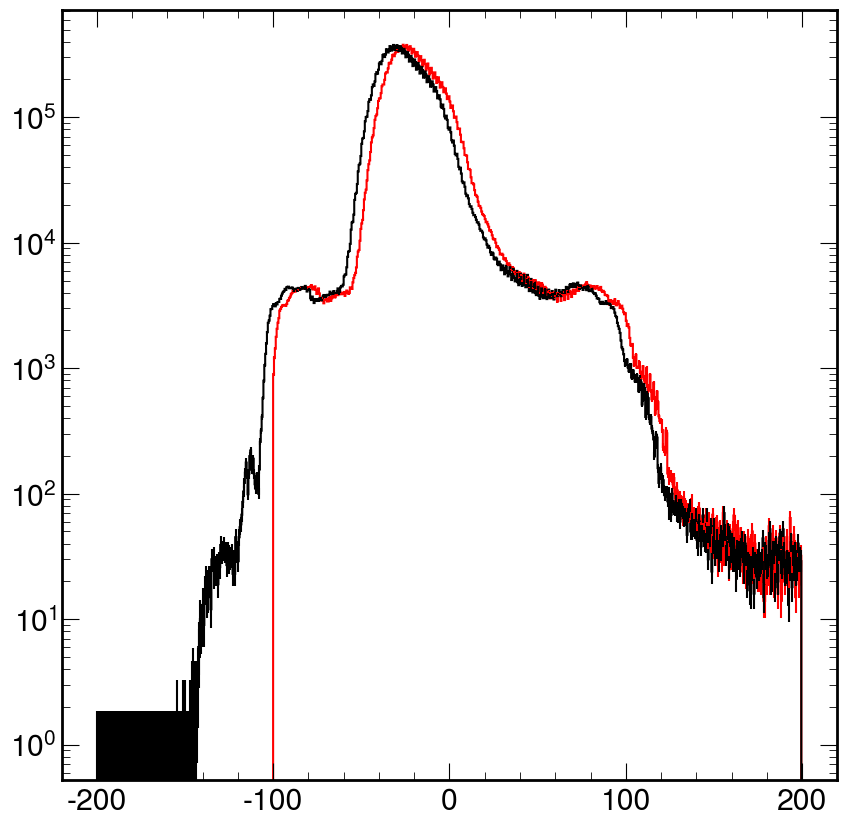

In [60]:
ambe_pos = np.array([0, 0, 298.0])
tof = np.linalg.norm(pmtinfo['pos'] - ambe_pos, axis=1)/299.792458 * 1.34
tof_lcn = {lcn: tof for lcn, tof in zip(pmtinfo['lcn'], tof)}
good_channels = np.array([lcn in tof_lcn for lcn in all_lcns])
all_tof = np.array([tof_lcn[lcn] for lcn in all_lcns[good_channels]])
tresid_hist = np.histogram(all_fitted_times[good_channels] - cabel_delay_for_hits[good_channels], bins=np.arange(-100, 200, 0.5))
hep.histplot(tresid_hist, yerr=True, color='r')

tresid_hist = np.histogram(all_fitted_times[good_channels] - cabel_delay_for_hits[good_channels] - all_tof, bins=np.arange(-200, 200, 0.5))
hep.histplot(tresid_hist, yerr=True, color='k')
plt.semilogy()


In [101]:
def get_tresid(evt):
    evt_times = fitted_times[evt]
    evt_lcns = lcns[evt]
    good_hits = evt_times < 9000
    evt_times = evt_times[good_hits]
    evt_lcns = evt_lcns[good_hits]
    evt_cabel_delay = CABLE_DELAYS[evt_lcns]
    evt_tof = np.array([tof_lcn[lcn] for lcn in evt_lcns])
    evt_tresid = evt_times - evt_cabel_delay - evt_tof
    return evt_tresid

tresid_means = []
tresid_std = []
tresid_nhits = []
for evt in trange(len(fitted_times)):
    # Prompt events
    if nhits[evt] > 75: continue # Muons
    if nhits[evt] < 25: continue # Radiologicals
    evt_tresid = get_tresid(evt)
    tresid_means.append(np.mean(evt_tresid))
    tresid_std.append(np.std(evt_tresid))
    tresid_nhits.append(len(evt_tresid))

tresid_means = np.array(tresid_means)
tresid_std = np.array(tresid_std)
tresid_nhits = np.array(tresid_nhits)



100%|██████████| 499539/499539 [03:46<00:00, 2208.72it/s]


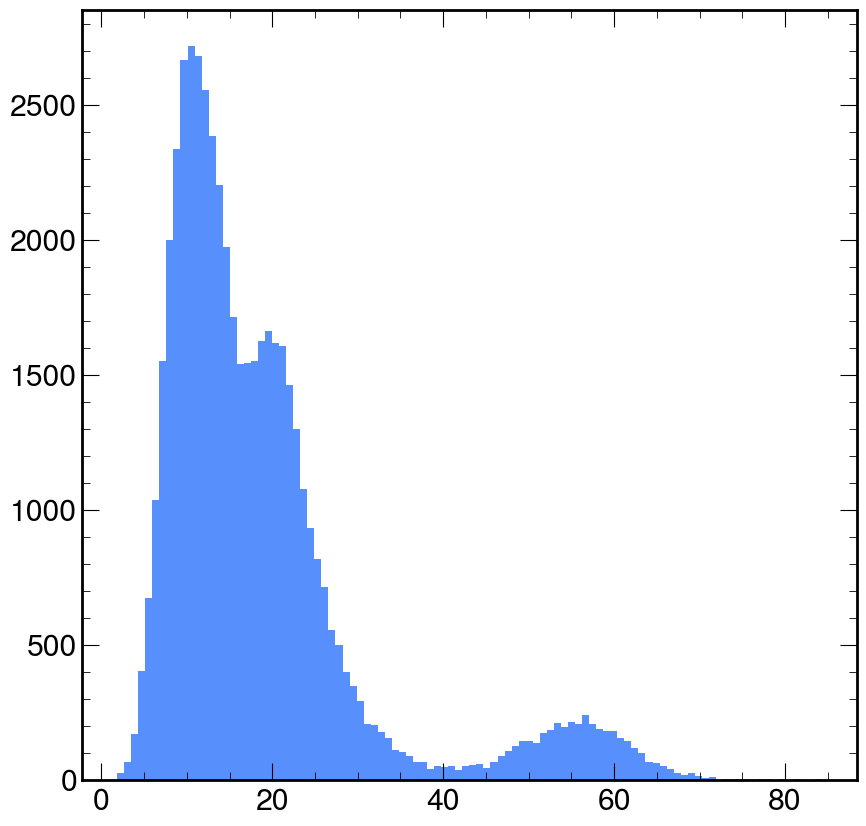

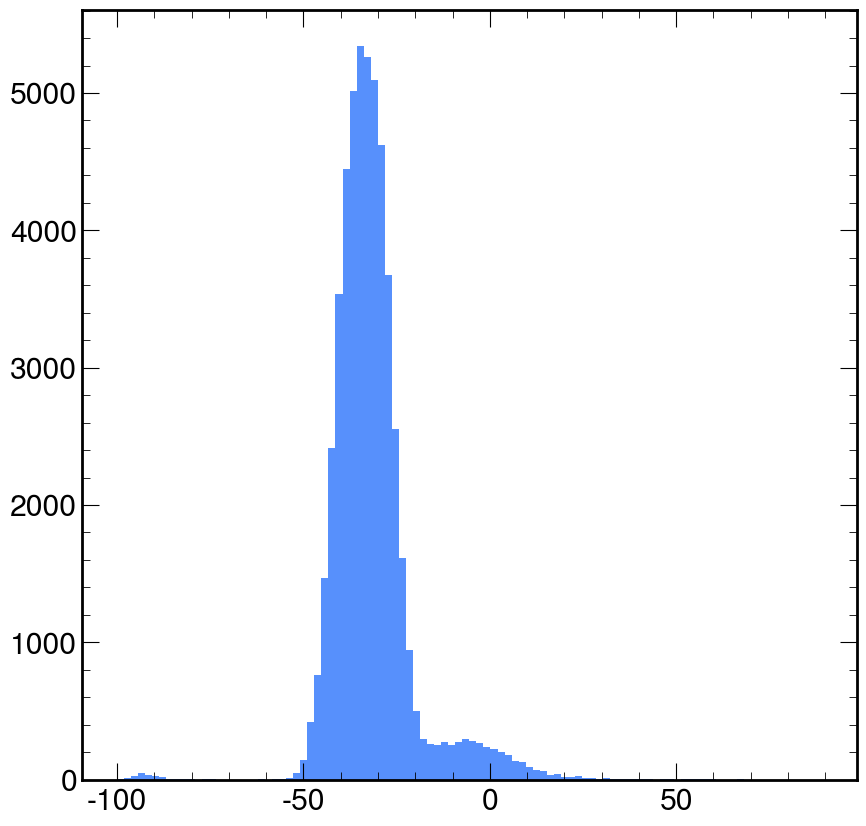

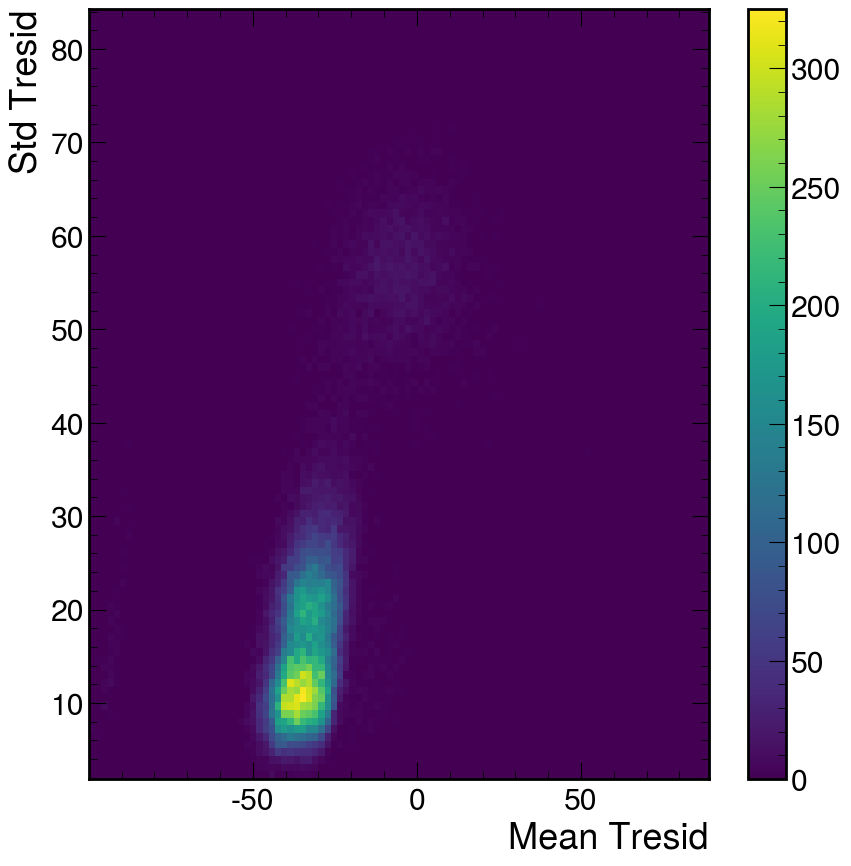

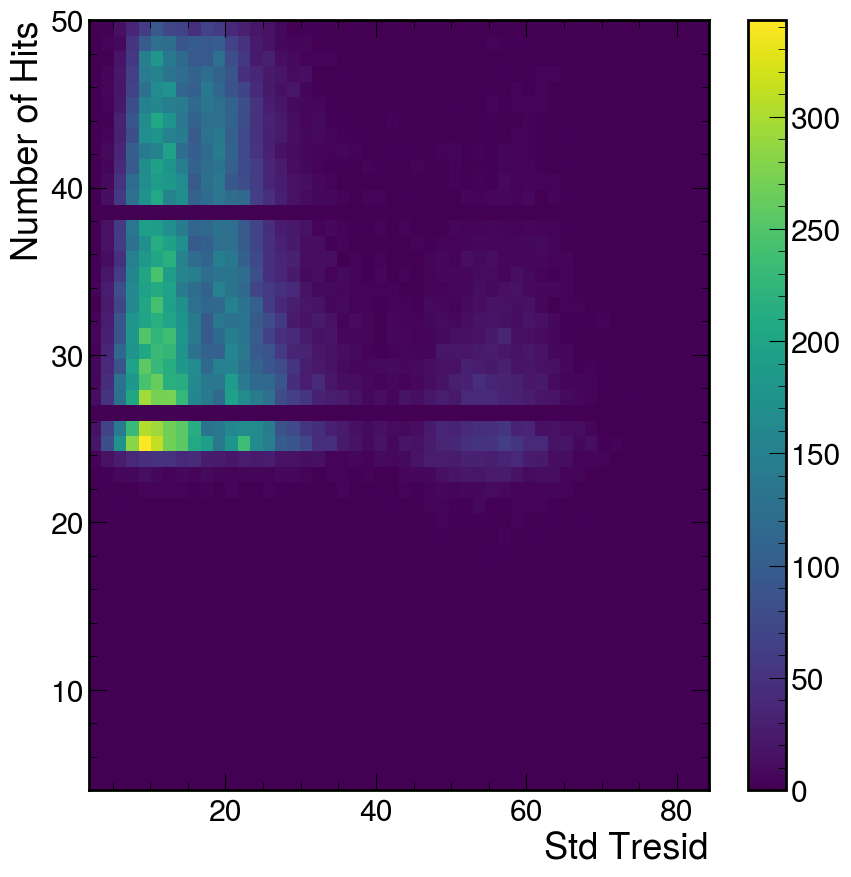

In [100]:
plt.hist(tresid_std, bins=100)
plt.figure()
plt.hist(tresid_means, bins=100)
plt.figure()
plt.hist2d(tresid_means, tresid_std, bins=100)
plt.colorbar()
plt.xlabel("Mean Tresid")
plt.ylabel("Std Tresid")
plt.figure()
plt.hist2d(tresid_std, tresid_nhits, bins=50)
plt.colorbar()
plt.xlabel("Std Tresid")
plt.ylabel("Number of Hits")
plt.show()